# Code to generate Figure 5(b)

In [9]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from utils.svm import LinearSupportVectorMachine_noOffset
from utils.RandFourier import RandomFourier
from utils.functions import * 

from IPython.display import display, clear_output
    
import matplotlib
import matplotlib.pyplot as plt

figwidth = 8
figheight = 4


## Load and preprocess the data

In [10]:
# Load Dataset
X, Y, labels = load_wdbc()

# Creat Train and Test sets
X_train, X_test, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=1)
y_train = np.asarray(ytrain)
y_test = np.asarray(ytest)

# Preprocess
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Set parameters

In [11]:
n = X_train_scaled.shape[0] # number of training data points
C = np.sqrt(n) # SVM parameter should scale as such (consistent classifier)
print("C:",C)

# number of features (should be an even number)
F = int(2*50) 

C: 19.949937343260004


## Find a prototype for each class

In [12]:
# prototype[0]: class 1
# prototype[1]: class -1

prototype = [np.mean(X_train_scaled[y_train == 1], axis=0), np.mean(X_train_scaled[y_train == -1], axis=0)]


## Fix noise and vary probability p and average over many realizations

In [13]:
gran = 10 # the number of betas to generate
rep = 10 # sample size for averaging noise (choose high to get smoother curves)

# probablity for the probabilistic constraint
proba_v = np.linspace(0.5, 0.99, num=gran, endpoint=True)

# beta
beta = 5

# noise scale: lambda
lam = 4*C*np.sqrt(F)/(beta*n)

accuracy = np.zeros((rep))
distance_to_proto = np.zeros((rep))
accuracy_private = np.zeros((rep,gran))

explainability = np.zeros((rep,gran))
explainability_private = np.zeros((rep,gran))
explainability_robust = np.zeros((rep,gran))
explainability_private_strength = np.zeros((rep,gran))
explainability_robust_strength = np.zeros((rep,gran))

# Approximation of kernel
FM_transform = RandomFourier(n_components=F,random_state=1).fit(X_train_scaled)
X_train_FM = FM_transform.transform(X_train_scaled)
X_test_FM = FM_transform.transform(X_test_scaled)

# Train classifier
SVM = LinearSupportVectorMachine_noOffset(C=C)
SVM.fit(X_train_FM, y_train)
    
# without noise
# -------------
## accuracy 
accuracy = sum(np.sign(SVM.predict(X_test_FM).flatten()) == y_test)/len(y_test) 
    
# Iteration: noise and approximation sample
for rep_idx in range(rep):

    np.random.seed(seed=rep_idx)
    
    # selected instance to explain
    idx_selected = np.random.randint(0,len(X_test))
    instance = X_test_scaled[idx_selected]
    instance_transformed = FM_transform.transform(instance.reshape(1, -1))
    prediction_instance = np.sign(SVM.predict(instance_transformed).flatten())
    selected_prototype = prototype[np.where(prediction_instance != [1,-1])[0][0]]
    
    ## explainability without noise
    explanation, plot_convergence = bisection_chance(instance, prediction_instance, selected_prototype, SVM, FM_transform)
    explainability[rep_idx] = np.linalg.norm(explanation-instance)
    
    distance_to_proto[rep_idx] = np.linalg.norm(selected_prototype-instance)
    
    # noise
    # -----
    mu = np.random.laplace(loc=0.0, scale=lam, size=(1,F))
        
    # Iteration: noise scale  
    for p_idx in range(gran):

        ## accuracy
        accuracy_private[rep_idx,p_idx] = sum(np.sign(SVM.predict(X_test_FM, mu).flatten()) == y_test)/len(y_test)
        
        ## explainability non-robust
        explanation_private, plot_convergence = bisection_chance(instance, prediction_instance, selected_prototype, SVM, FM_transform, mu)
        explainability_private[rep_idx,p_idx] = np.linalg.norm(explanation_private-instance)
        explainability_private_strength[rep_idx,p_idx] = prediction_instance*SVM.predict(FM_transform.transform(explanation_private.reshape(1, -1)), noise=0).flatten()
    
        ## explainability robust
        explanation_robust, plot_convergence = bisection_chance(instance, prediction_instance, selected_prototype, SVM, FM_transform, mu, lam, p=proba_v[p_idx])
        explainability_robust[rep_idx,p_idx] = np.linalg.norm(explanation_robust-instance)
        explainability_robust_strength[rep_idx,p_idx] = prediction_instance*SVM.predict(FM_transform.transform(explanation_robust.reshape(1, -1)), noise=0).flatten()
    
        clear_output(wait=True)
        display("Iteration for averaging: "+str(rep_idx+1)+ '/' +str(rep) +" -- Iteration on Beta: "+ str(p_idx+1)+ '/' +str(gran)) 
        

'Iteration for averaging: 10/10 -- Iteration on Beta: 10/10'

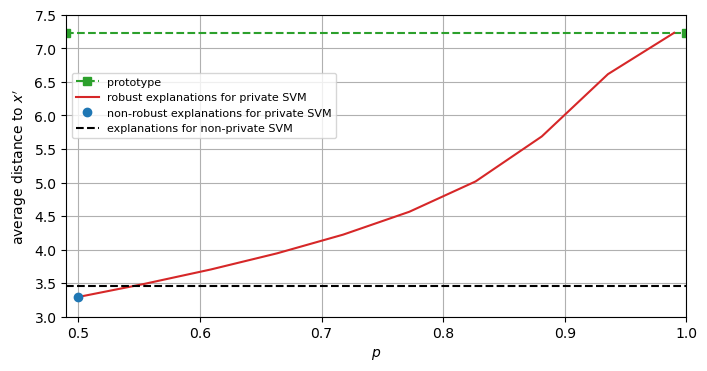

In [14]:
# Plot
fig, ax = plt.subplots(figsize=[figwidth, figheight], dpi=100)
ax.axhline(y=np.mean(distance_to_proto), c='tab:green', ls='--', marker='s', label=r'prototype')
ax.plot(proba_v,np.mean(explainability_robust, axis=0), c="tab:red", ls='-', label='robust explanations for private SVM')
ax.plot(0.5,np.mean(explainability_robust[:,0], axis=0), c="tab:blue",ls='', marker='o', label='non-robust explanations for private SVM')
#ax.plot(proba_v,np.mean(explainability_private, axis=0), c="tab:blue", ls='-', marker='.', label='non-robust explanation of private SVM')
ax.axhline(y=np.mean(explainability), c='k', ls='--', label='explanations for non-private SVM')

ax.set(xlabel='$p$', ylabel="average distance to $x'$", title='')
ax.set_xlim((0.49,1))
ax.set_ylim((3,7.5))
ax.legend(bbox_to_anchor=(0, .7),loc='center left',fontsize=8)
ax.grid()
plt.show()